# Imports

In [ ]:
import rasterio
import rasterio.warp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shapely 
from shapely import Polygon, MultiPolygon 
import json

In [ ]:
from utilities.area import get_density_per_area
from utilities.geojson import filter_features_by_list, get_polygons

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

United Kingdom

In [ ]:
london_boroughs = [
    'City of London', 'Westminster', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Wandsworth', 'Lambeth',
    'Southwark', 'Tower Hamlets', 'Hackney', 'Islington', 'Camden', 'Brent', 'Ealing', 'Hounslow', 'Richmond upon Thames',
    'Kingston upon Thames', 'Merton', 'Sutton', 'Croydon', 'Bromley', 'Lewisham', 'Greenwich', 'Bexley', 'Havering',
    'Barking and Dagenham', 'Redbridge', 'Newham', 'Waltham Forest','Haringey', 'Enfield', 'Barnet', 'Harrow',
    'Hillingdon'
]
inner_city_boroughs = [
    'Islington', 'Camden', 'Westminster', 'Southwark', 'Tower Hamlets', 'Hackney', 'Lambeth'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-GBR-ADM2-all/geoBoundaries-GBR-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
london_borough_features = filter_features_by_list(shape_data, 'shapeName', london_boroughs)
london_borough_polygons = get_polygons(london_borough_features, mainland=True)

France

In [ ]:
paris_departments = [
    'Paris', 'Val-de-Marne', 'Hauts-de-Seine', 'Seine-Saint-Denis'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-FRA-ADM2-all/geoBoundaries-FRA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
paris_department_features = filter_features_by_list(shape_data, 'shapeName', paris_departments)
paris_department_polygons = get_polygons(paris_department_features, mainland=True)

Manila, Philipines

In [ ]:
manila_divisons = [
    'NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-PHL-ADM2-all/geoBoundaries-PHL-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
manila_divison_features = filter_features_by_list(shape_data, 'shapeName', manila_divisons)
print(len(manila_divison_features))
manila_divison_polygons = get_polygons(manila_divison_features, mainland=True)

4


New York, USA

- change second 'Richmond' to 'Richmond, NY'
- change second 'Kings' to 'Kings, NY'

In [ ]:
geojson_filepath = 'data/geoBoundaries-USA-ADM2-all/geoBoundaries-USA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
new_york_counties = ['New York', 'Bronx', 'Kings, NY', 'Queens', 'Richmond, NY']

In [ ]:
new_york_features = filter_features_by_list(shape_data, 'shapeName', new_york_counties)
new_york_polygons = get_polygons(new_york_features) 

Gaza

In [ ]:
gaza_strip_districts = [
    'Gaza', 'Khan Yunis', 'Rafah', 'North Gaza', 'Deir Al Balah'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-PSE-ADM2-all/geoBoundaries-PSE-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    palestine_data = json.load(f)
    
gaza_features = filter_features_by_list(palestine_data, 'shapeName', gaza_strip_districts)
gaza_polygons = get_polygons(gaza_features)

## Plot at origin

-------------London-------------
City of London : 3,738 people: 1493.35 people/km^2
Barking and Dagenham : 215,816 people: 5852.23 people/km^2
Barnet : 396,698 people: 4583.75 people/km^2
Bexley : 237,836 people: 3941.20 people/km^2
Brent : 372,695 people: 8447.67 people/km^2
Bromley : 327,410 people: 2182.49 people/km^2
Camden : 234,732 people: 11047.16 people/km^2
Croydon : 391,623 people: 4559.43 people/km^2
Ealing : 363,294 people: 6647.41 people/km^2
Enfield : 354,982 people: 4280.90 people/km^2
Greenwich : 291,879 people: 6135.76 people/km^2
Hackney : 299,252 people: 15105.74 people/km^2
Hammersmith and Fulham : 205,193 people: 11681.18 people/km^2
Haringey : 288,864 people: 10094.05 people/km^2
Harrow : 273,695 people: 5290.88 people/km^2
Havering : 249,263 people: 2192.69 people/km^2
Hillingdon : 312,777 people: 2710.44 people/km^2
Hounslow : 296,252 people: 5386.77 people/km^2
Islington : 242,125 people: 15997.60 people/km^2
Kensington and Chelsea : 151,047 people: 12923.35 pe

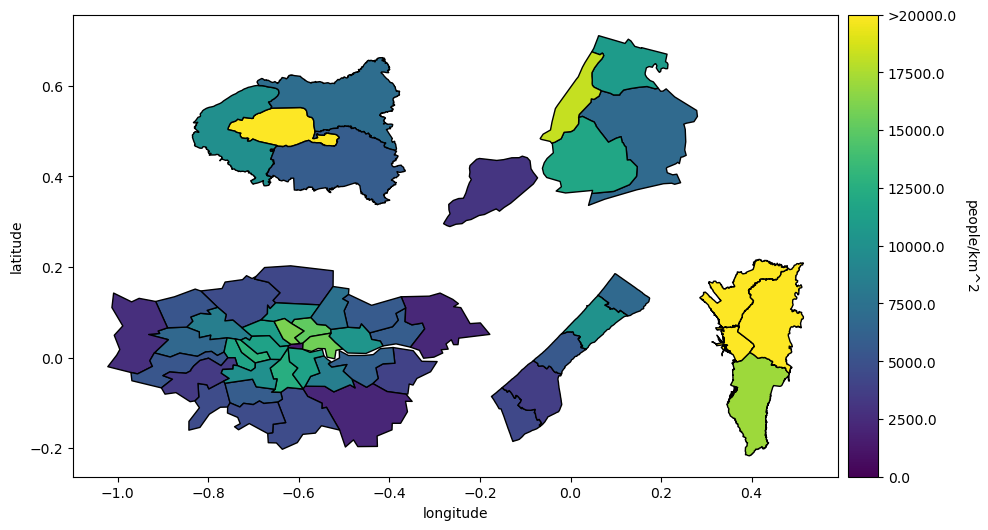

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6));
vmax = 20_000

for region_name, region_polygons, filepath, offset in [
    ('London', london_borough_polygons, 'data/gbr_ppp_2020_constrained.tif', np.array((-0.6, 0))),
    ('Manila', manila_divison_polygons, 'data/phl_ppp_2020_constrained.tif',np.array((0.4, 0.0))),
    ('New York', new_york_polygons, 'data/usa_ppp_2020_constrained.tif', np.array((0.0, 0.5))),
    ('Paris', paris_department_polygons, 'data/fra_ppp_2020_constrained.tif', np.array((-0.6, 0.5))),
    ('Gaza', gaza_polygons, 'data/pse_ppp_2020_constrained.tif', np.array((0, 0))),
    ]:
    patches = []
    colors = []
    long_min, lat_min, long_max, lat_max = MultiPolygon(region_polygons.values()).bounds
    long_avg = (long_min + long_max) /2
    lat_avg = (lat_max + lat_min) /2
    for polygon in region_polygons.values(): 
        translated_polygon = polygon.exterior.coords - np.array((long_avg, lat_avg)) + offset
        patches.append(matplotlib.patches.Polygon(translated_polygon))

    with rasterio.open(filepath) as src:
        densities, populations_counts,areas = get_density_per_area(src, region_polygons.values())
    
    print('-------------' + region_name + '-------------')
    total_population = 0
    for (name, density, pop) in zip(region_polygons.keys(), densities, populations_counts):
        print(f'{name} : {pop:,.0f} people: {density:.2f} people/km^2')
        total_population += pop
    print(f'total population: {total_population:,.0f}')

    p = matplotlib.collections.PatchCollection(patches, edgecolor='k')
    colors = densities
    p.set_array(colors)
    p.set_clim(0, vmax)
    axis_image = ax.add_collection(p)
    
ax.autoscale()
ax.set_aspect('equal')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

#fig.colorbar(axis_image)
cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = fig.colorbar(p, cbar_axis)
cbar.set_label('people/km^2', rotation=270, labelpad=15) # density
ticks = cbar.ax.get_yticks()
tick_labels = [f'{x}' for x in ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

In [ ]:
long_min, long_max = ax.get_xlim() 
lat_min, lat_max = ax.get_ylim()

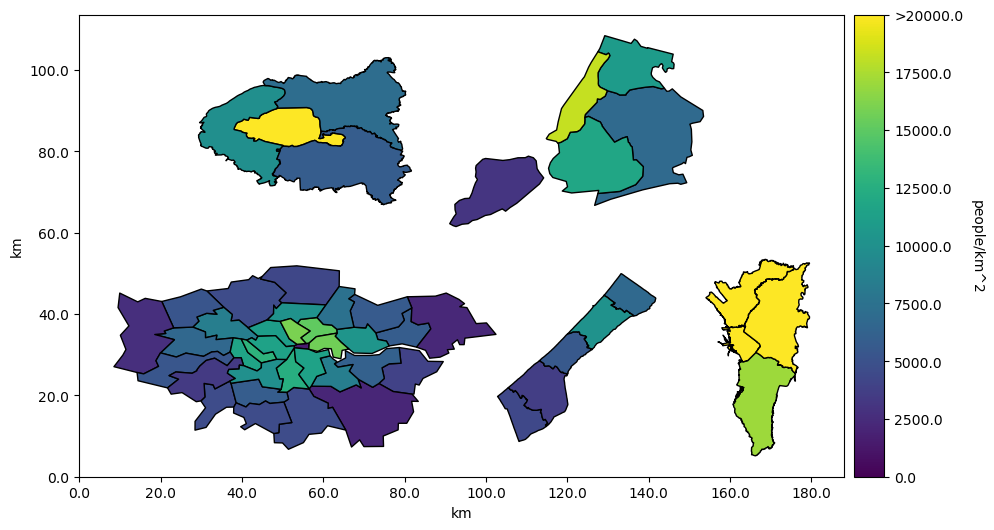

In [ ]:
width = (long_max - long_min)
height = lat_max - lat_min

EARTH_RADIUS = 6378137
y_height = (lat_max - lat_min) * np.pi / 180 * EARTH_RADIUS # degree * rad/degree * m
x_width = (long_max - long_min) * np.pi / 180 * EARTH_RADIUS * np.cos(0 * np.pi / 180) # at equator

x_ticklabels = np.arange(0, x_width, 20_000)
x_ticks = x_ticklabels * 180 / np.pi / EARTH_RADIUS + long_min
x_ticklabels /= 1000
y_ticklabels = np.arange(0, y_height, 20_000)
y_ticks = y_ticklabels * 180 / np.pi / EARTH_RADIUS + lat_min
y_ticklabels /= 1000
x_unit = 'km'
y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
fig

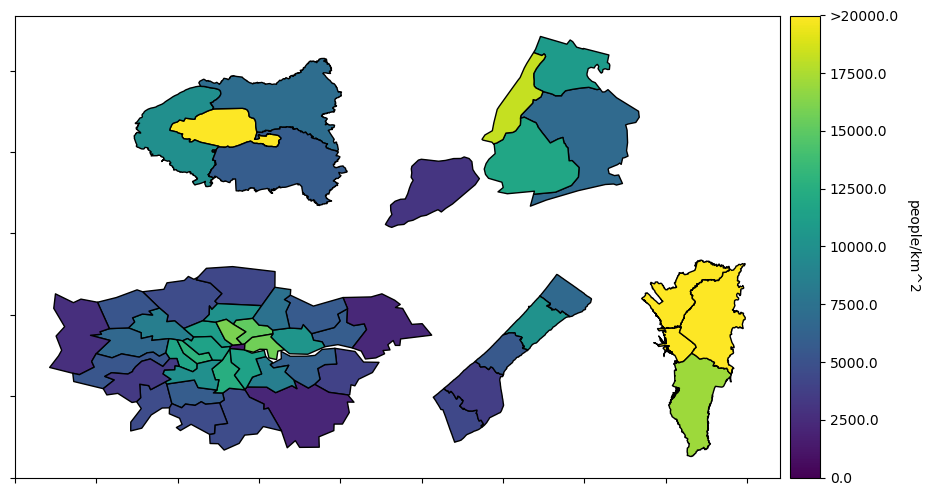

In [ ]:
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
fig    

In [ ]:
fig.savefig('all_densities.png', bbox_inches="tight")